In [1]:
#MiniProject Code - Naive Bayes

import pandas as pd
import os
import glob

#Setup of dataset path
base_folder = os.path.join("/Users/jpsalvador/Downloads/FINAL FOOD DATASET")
csv_pattern = os.path.join(base_folder, "FOOD-DATA-GROUP*.csv")

#Features to be used, same with what was written for AdaBoost

feature_cols = [
    "Protein", "Fat", "Carbohydrates", "Caloric Value",
    "Sugars", "Dietary Fiber", "Saturated Fats",
    "Monounsaturated Fats", "Polyunsaturated Fats",
    "Sodium", "Potassium"
]

#Loading of dataset
csv_files = glob.glob(csv_pattern)
print("CSV files found:", csv_files)

#Loading of files and combining 
dataframes = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

print("\n\nTotal rows before cleaning:", len(df))

#Cleaning by dropping rows with missing values
df = df.dropna(subset=feature_cols)
print("Total rows after cleaning:", len(df))
print(df.head())

CSV files found: ['/Users/jpsalvador/Downloads/FINAL FOOD DATASET/FOOD-DATA-GROUP1.csv', '/Users/jpsalvador/Downloads/FINAL FOOD DATASET/FOOD-DATA-GROUP3.csv', '/Users/jpsalvador/Downloads/FINAL FOOD DATASET/FOOD-DATA-GROUP2.csv', '/Users/jpsalvador/Downloads/FINAL FOOD DATASET/FOOD-DATA-GROUP5.csv', '/Users/jpsalvador/Downloads/FINAL FOOD DATASET/FOOD-DATA-GROUP4.csv']


Total rows before cleaning: 2395
Total rows after cleaning: 2395
   Unnamed: 0.1  Unnamed: 0                              food  Caloric Value  \
0             0           0                      cream cheese             51   
1             1           1                 neufchatel cheese            215   
2             2           2  requeijao cremoso light catupiry             49   
3             3           3                    ricotta cheese             30   
4             4           4              cream cheese low fat             30   

    Fat  Saturated Fats  Monounsaturated Fats  Polyunsaturated Fats  \
0   5.0 

In [2]:
#Assignment of Labels

def assign_label(row):
    """
    Assignment of labels using the following criteria:
    Muscle Gain if Protein >=15 OR (Protein >=10 AND Caloric Value >= 200)
    Endurance if Carbohydrates >= 30 OR Sugars >= 12 OR (Carbohydrates >=20 AND Sodium >= 140)
    Weight Loss if Caloric Value < 150 AND Fat < 5 AND (Carbohydrates < 20 OR Dietary Fiber >= 3)
    
    Assignment of labels will be done in that order of priority.
    """

    #MUSCLE GAIN
    muscle_gain = (
        (row["Protein"] >= 15) or
        (row["Protein"] >= 10 and row["Caloric Value"] >= 200)
    )

    #ENDURANCE
    endurance = (
        (row["Carbohydrates"] >= 30) or
        (row["Sugars"] >= 12) or
        (row["Carbohydrates"] >= 20 and row["Sodium"] >= 140)
    )

    #WEIGHT LOSS
    weight_loss = (
        (row["Caloric Value"] < 150) and
        (row["Fat"] < 5) and
        ((row["Carbohydrates"] < 20) or (row["Dietary Fiber"] >=3))
    )

    #ASSIGNMENT BASED ON PRIORITY
    if muscle_gain:
        return "Muscle Gain"
    if endurance:
        return "Endurance"
    if weight_loss:
        return "Weight Loss"
    return "No Category"

#Tagging of labels
df["Label"] = df.apply(assign_label, axis=1)
label_counts = df["Label"].value_counts()
print(label_counts)


Label
Weight Loss    1016
Muscle Gain     649
Endurance       386
No Category     344
Name: count, dtype: int64


In [3]:
#Naive Bayes

def run_naive_bayes(df, feature_cols):
    """
    This is the function to run the Gaussian Naive Bayes
    """
    
    #Dropping the No Category rows
    df_model = df[df["Label"] != "No Category"].copy()
    # df_model = df.copy() Tried to include "No Category" but got lower results
    X = df_model[feature_cols].values
    y = df_model["Label"].values
    
    #Cross-Validation
    from sklearn.naive_bayes import GaussianNB
    from sklearn.model_selection import cross_val_score
    
    #Setting of Gaussian Naive Bayes as the NB Algorithm to be used
    nb_model = GaussianNB()
    

    
    #METRICS
    cv_recall = cross_val_score(nb_model, X, y, cv = 5, scoring = 'recall_macro')
    cv_precision = cross_val_score(nb_model, X, y, cv = 5, scoring = 'precision_macro')
    cv_f1 = cross_val_score(nb_model, X, y, cv = 5, scoring = 'f1_macro')
    cv_accuracy = cross_val_score(nb_model, X, y, cv=5, scoring = 'accuracy')
    
    print("\n\n===== GAUSSIAN NAIVE BAYES RESULTS =====")
    #For checking only
    print("Shape of X:", X.shape)
    print("Example row from X:", X[0])
    print("Length of y:", len(y))
    print("Unique Labels:", set(y))
    print("\n")
    print(df_model["Label"].value_counts())
    print("\nMETRICS")
    print("Accuracy scores:", cv_accuracy)
    print("Average Accuracy:", cv_accuracy.mean())
    print("\nRecall scores:", cv_recall)
    print("Average Recall:", cv_recall.mean())
    print("\nPrecision scores:", cv_precision)
    print("Average Precision:", cv_precision.mean())
    print("\nF1 scores:", cv_f1)
    print("Average F1:", cv_f1.mean())

    return {
        "accuracy": cv_accuracy.mean(),
        "precision": cv_precision.mean(),
        "recall": cv_recall.mean(),
        "f1": cv_f1.mean
    }

In [4]:
#SVM

def run_svm_rbf(df, feature_cols):
    """
    This is runs the SVM (RBF Kernel) algorithm.
    """

    #Same setup of removing the 'No Category' wors
    df_model = df[df["Label"] != "No Category"].copy()

    X = df_model[feature_cols].values
    y = df_model["Label"].values
    
    #Importing of libraries for SVM
    from sklearn.svm import SVC
    from sklearn.preprocessing import StandardScaler #needed since the features aren't of the same scale
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import cross_val_score, GridSearchCV

    #SVM Pipeline -- scaling and classifier
    svm_model = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", random_state=42))
    ])

    #Grid Search
    param_grid = {
        "svc__C": [0.1, 1, 10],
        "svc__gamma": [0.01, 0.1, 1]
    }

    grid_search = GridSearchCV(
        estimator=svm_model,
        param_grid=param_grid,
        scoring="f1_macro", #This is the one being optimized
        cv=5 #5-fold cross-validation
    )

    print("\nRunning GridSearchCV for SVM...")
    grid_search.fit(X,y)
    print("\n===== SVM (RBF) GRID SEARCH RESULTS =====")
    print("Best parameters:", grid_search.best_params_)
    print("Best CV F1-macro from GridSearch:", grid_search.best_score_)

    #Using the best Model from GridSearchCV
    best_svm_model = grid_search.best_estimator_

    #METRICS
    cv_recall = cross_val_score(best_svm_model, X, y, cv = 5, scoring = 'recall_macro')
    cv_precision = cross_val_score(best_svm_model, X, y, cv = 5, scoring = 'precision_macro')
    cv_f1 = cross_val_score(best_svm_model, X, y, cv = 5, scoring = 'f1_macro')
    cv_accuracy = cross_val_score(best_svm_model, X, y, cv=5, scoring = 'accuracy')

    print("\n\n===== SVM (RBF) RESULTS =====")
     #For checking only
    print("Shape of X:", X.shape)
    print("Example row from X:", X[0])
    print("Length of y:", len(y))
    print("Unique Labels:", set(y))
    print("\n")
    print(df_model["Label"].value_counts())
    print("\nMETRICS")
    print("Accuracy scores:", cv_accuracy)
    print("Average Accuracy:", cv_accuracy.mean())
    print("\nRecall scores:", cv_recall)
    print("Average Recall:", cv_recall.mean())
    print("\nPrecision scores:", cv_precision)
    print("Average Precision:", cv_precision.mean())
    print("\nF1 scores:", cv_f1)
    print("Average F1:", cv_f1.mean())

    return {
        "best_params": grid_search.best_params_,
        "gridsearch_best_f1": grid_search.best_score_,
        "accuracy": cv_accuracy.mean(),
        "precision": cv_precision.mean(),
        "recall": cv_recall.mean(),
        "f1": cv_f1.mean
    }

In [5]:
#CALLING OF THE FUNCTIONS

nb_results = run_naive_bayes(df,feature_cols)
svm_results = run_svm_rbf(df, feature_cols)



===== GAUSSIAN NAIVE BAYES RESULTS =====
Shape of X: (2051, 11)
Example row from X: [ 0.8  3.6  0.9 49.   3.4  0.1  2.3  0.9  0.   0.   0. ]
Length of y: 2051
Unique Labels: {'Weight Loss', 'Muscle Gain', 'Endurance'}


Label
Weight Loss    1016
Muscle Gain     649
Endurance       386
Name: count, dtype: int64

METRICS
Accuracy scores: [0.87347932 0.89756098 0.90243902 0.93170732 0.85365854]
Average Accuracy: 0.891769034478666

Recall scores: [0.86425632 0.87421199 0.89791128 0.91885471 0.85292524]
Average Recall: 0.8816319079864531

Precision scores: [0.85371738 0.86673314 0.87667136 0.91885471 0.83497036]
Average Precision: 0.8701893903106768

F1 scores: [0.84385223 0.87018346 0.88229028 0.91885471 0.82622815]
Average F1: 0.8682817646374117

Running GridSearchCV for SVM...

===== SVM (RBF) GRID SEARCH RESULTS =====
Best parameters: {'svc__C': 10, 'svc__gamma': 0.01}
Best CV F1-macro from GridSearch: 0.9205782940156929


===== SVM (RBF) RESULTS =====
Shape of X: (2051, 11)
Example r

====== ANOVA RESULTS ======
                 Feature     F_score        p_value
29            Phosphorus  425.669193  2.557360e-155
7                Protein  402.304507  4.303354e-148
0          Caloric Value  395.085269  7.770699e-146
5          Carbohydrates  311.226861  9.522996e-119
30             Potassium  282.221456  5.571074e-109
33     Nutrition Density  253.123871   5.814877e-99
27             Magnesium  248.170315   3.110370e-97
6                 Sugars  244.574352   5.644779e-96
17            Vitamin B3  234.010470   2.954457e-92
1                    Fat  184.535626   2.058123e-74
2         Saturated Fats  154.510566   3.174472e-63
32                  Zinc  151.126335   6.033472e-62
24               Calcium  147.349741   1.629640e-60
19            Vitamin B6  137.506519   9.225385e-57
26                  Iron  135.623675   4.858169e-56
3   Monounsaturated Fats  120.809898   2.536172e-50
18            Vitamin B5  103.628755   1.345941e-43
11                 Water  102.917011

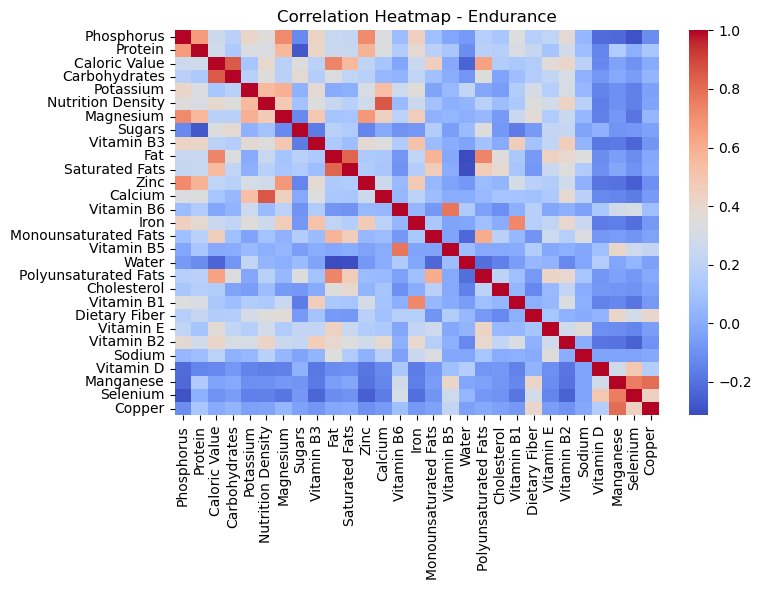

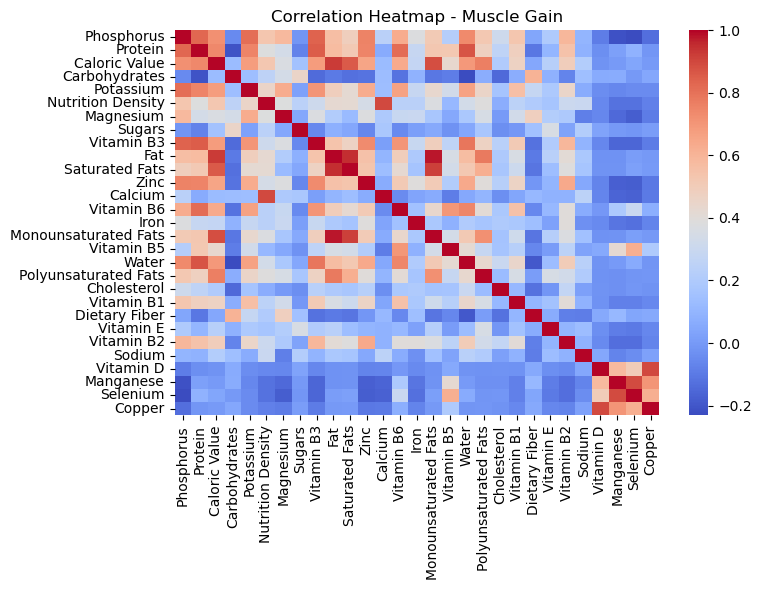

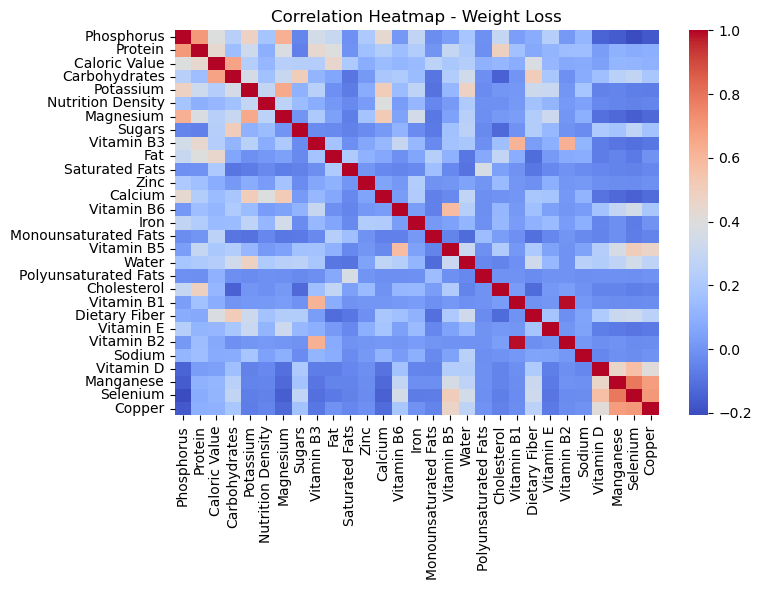

===== MEAN NUTRIENT VALUES (SIGNIFICANT FEATURES ONLY) =====
             Phosphorus    Protein  Caloric Value  Carbohydrates   Potassium  \
Label                                                                          
Endurance     76.800096   3.686140     237.274611      44.452016  257.467617   
Muscle Gain  455.601367  42.005701     520.040062      27.473948  759.154237   
Weight Loss   29.020274   2.068576      43.554134       5.946410  100.438369   

             Nutrition Density  Magnesium     Sugars  Vitamin B3        Fat  \
Label                                                                         
Endurance           114.242881  29.224611  18.015210    1.288238   5.386650   
Muscle Gain         228.799391  86.853159   2.653282    8.846712  26.705239   
Weight Loss          42.522235  10.380302   1.568665    0.569389   0.960125   

             ...  Cholesterol  Vitamin B1  Dietary Fiber  Vitamin E  \
Label        ...                                                      


/opt/anaconda3/envs/name_of_my_env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
#FEATURE IMPORTANCE
#In our paper, we declared that "On the other hand, the macronutrient trends of food within each fitness label 
#will be determined by identifying feature importance using logistic regression."
#But in this section, we will also also do ANOVA, Correlation Heatmaps, Mean Profiles, and Logistic Regression

import pandas as pd

#Including all features for analysis
all_features = [
    "Caloric Value", "Fat", "Saturated Fats", "Monounsaturated Fats", "Polyunsaturated Fats",
    "Carbohydrates", "Sugars", "Protein", "Dietary Fiber", "Cholesterol",
    "Sodium", "Water",
    "Vitamin A", "Vitamin B1", "Vitamin B11", "Vitamin B12", "Vitamin B2",
    "Vitamin B3", "Vitamin B5", "Vitamin B6", "Vitamin C", "Vitamin D",
    "Vitamin E", "Vitamin K",
    "Calcium", "Copper", "Iron", "Magnesium", "Manganese",
    "Phosphorus", "Potassium", "Selenium", "Zinc",
    "Nutrition Density"
]

#Excluded "No Category" in the analysis
df_stats = df[df["Label"] != "No Category"].copy()
df_stats = df_stats.dropna(subset=all_features)

#ANOVA
from sklearn.feature_selection import f_classif

X_stats = df_stats[all_features].values
y_stats = df_stats["Label"].values

F_scores, p_values = f_classif(X_stats, y_stats)
anova_results = pd.DataFrame({
    "Feature": all_features,
    "F_score": F_scores,
    "p_value": p_values
})

anova_results_sorted = anova_results.sort_values("F_score", ascending=False)

print("====== ANOVA RESULTS ======")
print(anova_results_sorted)

#Statistically significant features
alpha=0.05
significant_features = anova_results_sorted[anova_results_sorted["p_value"] < alpha]["Feature"].tolist()

print("\nSignificant features (p <0.05):")
print(significant_features)

#If no significant features, use all
if len(significant_features) == 0:
    significant_features = feature_cols.copy()
    print("\nNo significant features found. Using all features instead.")


#CORRELATION HEATMAPS PER CLASS
import seaborn as sns #Data Visualization Library
import matplotlib.pyplot as plt

features_to_plot = significant_features

for label in sorted(df_stats["Label"].unique()):
    subset = df_stats[df_stats["Label"] == label][features_to_plot]

    plt.figure(figsize=(8,6))
    sns.heatmap(
        subset.corr(),
        cmap="coolwarm",
        annot=False
    )
    plt.title(f"Correlation Heatmap - {label}")
    plt.tight_layout()
    plt.show()

#MEAN NUTRIENT PROFILES (ONLY SIGNIFICANT FEATURES)
mean_table = df_stats.groupby("Label")[features_to_plot].mean()
print("===== MEAN NUTRIENT VALUES (SIGNIFICANT FEATURES ONLY) =====")
print(mean_table)

#LOGISTIC REGRESSION FEATURE IMPORTANCE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_lr = df_stats[all_features].values
y_lr = df_stats["Label"].values

#Scale Features
scaler_lr = StandardScaler()
X_lr_scaled = scaler_lr.fit_transform(X_lr)

logreg = LogisticRegression(
    multi_class = "multinomial",
    max_iter = 500,
    random_state = 42
)

logreg.fit(X_lr_scaled, y_lr)

coef_table = pd.DataFrame(
    logreg.coef_,
    columns = all_features,
    index = logreg.classes_
)

print("\n===== LOGISTIC REGRESSION COEFFICIENTS (ALL FEATURES) ======")
print(coef_table)

#Only Significant Features
coef_sig = coef_table[significant_features]
print("\n===== LOGISTIC REGRESSION COEFFICIENTS (SIGNIFICANT FEATURES ONLY) ======")
print(coef_sig)